# **Линейная регрессия на реальных данных климатической модели ИВМ РАН версии INM-CM6P.** 

Используются <u>среднемесячные</u> поля - **температура поверхности океана (ТПО), температура воздуха на 2 м (Т2), давление на уровне моря (ДУМ) и атмосферные осадки (АО)** для периода января 1960 г. - декабря 2014 г. для точки с коррдинатами 15.75$^{\circ}$ с.ш., 60$^{\circ}$ з.д., расположенной в области распространения ЭНЮК. 

*Шаг модели - 1.5$^{\circ}$ от 90$^{\circ}$ ю.ш. до 90$^{\circ}$ с.ш. и 2$^{\circ}$ от 180$^{\circ}$ з.д. до 180$^{\circ}$ в.д.*

In [10]:
# импорт всех необходимых библиотек
import os
import sklearn
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

### Считываем данные как в прошлом задании

In [49]:
path = 'C:/Users/1/Videos/INMCM6P_data/historical'
file1 = 'SST_1960_2024.nc'
dataset1 = xr.open_dataset(os.path.join(path,file1))
dataset1['SST'] = dataset1['SST'] - 273.15 # переводим значения ТПО из градусов Кельвина в градусы Цельсия
df1 = dataset1.isel(time=slice(0, 660), lat=slice(70, 71), lon=slice(60, 61)).to_dataframe().reset_index() # вырезаем период 1960-2014 гг.
# и 1 точку по пространству в районе ЭНЮК
file2 = 'T2_1960_2024.nc' 
dataset2 = xr.open_dataset(os.path.join(path, file2))
dataset2['T2'] = dataset2['T2'] - 273.15 # переводим значения T2 из градусов Кельвина в градусы Цельсия
df2 = dataset2.isel(time=slice(0, 660), lat=slice(70, 71), lon=slice(60, 61)).to_dataframe().reset_index() # вырезаем период 1960-2014 гг.
# и 1 точку по пространству в районе ЭНЮК
file3 = 'PS_1960_2024.nc' 
dataset3 = xr.open_dataset(os.path.join(path, file3))['PS']
df3 = dataset3.isel(time=slice(0, 660), lat=slice(70, 71), lon=slice(60, 61)).to_dataframe().reset_index() # вырезаем период 1960-2014 гг.
# и 1 точку по пространству в районе ЭНЮК
file4 = 'PREC_1960_2024.nc' 
dataset4 = xr.open_dataset(os.path.join(path, file4))
dataset4['PREC'] = dataset4['PREC'] *30 # переводим значения АО из мм/сут в мм/мес
df4 = dataset4.isel(time=slice(0, 660), lat=slice(70, 71), lon=slice(60, 61)).to_dataframe().reset_index() # вырезаем период 1960-2014 гг.
# и 1 точку по пространству в районе ЭНЮК
dataframe = df1[['time', 'lat', 'lon', 'SST']].copy()
dataframe['T2'] = df2['T2']  
dataframe['PS'] = df3['PS'] 
dataframe['PREC'] = df4['PREC'] 
dataframe['time'] = pd.to_datetime(dataframe['time']).dt.strftime('%Y-%m') # переходим в более компактный формат записи времени - месяцы и годы
# т.к. у нас среднемесячные данные за 55 лет
dataframe = dataframe.set_index('time')
display(dataframe) 

,lat,lon,SST,T2,PS,PREC
time,,,,,,
1960-01,15.75,-60.0,24.563684,22.784052,1016.594604,57.730061
1960-02,15.75,-60.0,23.691187,22.297662,1017.168457,40.946360
1960-03,15.75,-60.0,23.696558,22.015161,1015.526978,27.165576
1960-04,15.75,-60.0,24.496667,23.617761,1014.915100,21.852676
1960-05,15.75,-60.0,24.893915,24.117120,1015.490417,26.074183
...,...,...,...,...,...,...
2014-08,15.75,-60.0,26.332025,25.601251,1015.648438,31.309744
2014-09,15.75,-60.0,26.847253,26.263116,1014.681458,78.975062
2014-10,15.75,-60.0,26.596277,25.471887,1015.254700,29.986264


In [50]:
dataframe = dataframe.apply(pd.to_numeric, errors='coerce') # преобразуем текстовые значения в числовые
display(dataframe.info())
dataframe.to_csv('C:/Users/1/Desktop/МО в гидрометеорологии/Task3/SST_1960_2024.csv') # сохраняем результаты в csv-файл

<class 'pandas.core.frame.DataFrame'>
Index: 660 entries, 1960-01 to 2014-12
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     660 non-null    float32
 1   lon     660 non-null    float32
 2   SST     660 non-null    float64
 3   T2      660 non-null    float64
 4   PS      660 non-null    float64
 5   PREC    660 non-null    float64
dtypes: float32(2), float64(4)
memory usage: 30.9+ KB


None

In [51]:
df = pd.read_csv('SST_1960_2024.csv', parse_dates=['time'])
df['time'] = df['time'].dt.strftime('%Y-%m')
df = df.set_index('time')
df.head()

,lat,lon,SST,T2,PS,PREC
time,,,,,,
1960-01,15.75,-60.0,24.563684,22.784052,1016.594604,57.730061
1960-02,15.75,-60.0,23.691187,22.297662,1017.168457,40.946360
1960-03,15.75,-60.0,23.696558,22.015161,1015.526978,27.165576
1960-04,15.75,-60.0,24.496667,23.617761,1014.915100,21.852676
1960-05,15.75,-60.0,24.893915,24.117120,1015.490417,26.074183


### Разделяем целевой признак (целевую переменную) и обучаем модель

In [69]:
target = 'SST'

df_Xy = df.copy()
df_Xy = df_Xy.dropna()

y = df_Xy[target] # целевая переменная - ТПО
X = df_Xy.drop(target, axis=1) # признаковое описание - Т2, ДУМ и АО

model = LinearRegression()
model.fit(X, y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### Применяем модель (к тем же данным, на которых она обучалась)

Text(0, 0.5, 'Predicted')

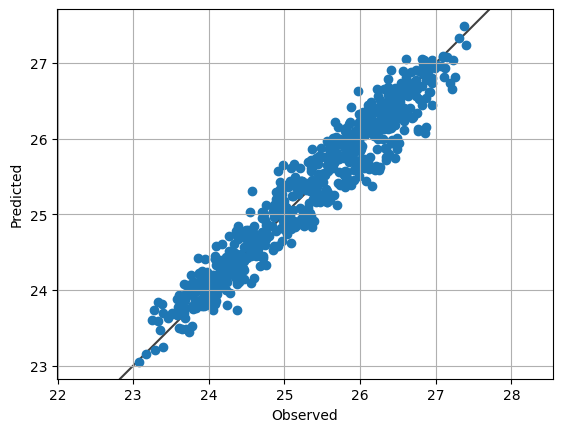

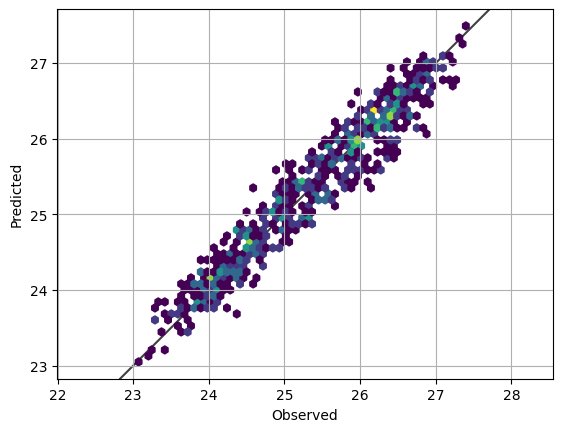

In [90]:
y_pred = model.predict(X)

plt.figure()
plt.scatter(y, y_pred)
plt.axis('equal')
ax = plt.gca()
lims = [
       np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
       np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
       ]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlim(lims)
plt.ylim(lims)
plt.grid()
plt.xlabel('Observed')
plt.ylabel('Predicted')

plt.figure()
plt.hexbin (y, y_pred, mincnt=1, gridsize=50)
plt.axis('equal')
ax = plt.gca()
lims = [
       np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
       np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
       ]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlim(lims)
plt.ylim(lims)
plt.grid()
plt.xlabel('Observed')
plt.ylabel('Predicted')

На основании полученных графиков можем сделать вывод, что используемая нами модель МО - модель линейной регрессии, **достаточно успешно прогнозирует ТПО** по данным Т2, ДУМ и АО

In [92]:
r = np.corrcoef(y_pred, y)[0,1] # вычисляем коэффициент корреляции
r2 = r2_score(y, y_pred) # вычисляем коэффициент детерминации
mse = mean_squared_error(y, y_pred)

print ('Коэффициент корреляции:', r)
print ('Коэффициент корреляции в квадрате:', r**2)
print ('Коэффициент детерминации:', r2)
print ('Среднеквадратичная ошибка:', np.sqrt(mse)) # вычисляем СКО

Коэффициент корреляции: 0.966510988051775
Коэффициент корреляции в квадрате: 0.9341434900248184
Коэффициент детерминации: 0.9341434900248184
Среднеквадратичная ошибка: 0.25838353948597403


Получаем большие значения коэффициентов корреляции (**крайне высокая** <u>положительная</u> связь между "реальными" и "моделируемыми" значениями ТПО) и детерминации (*модель интерпретирует практически всю изменчивость ТПО*) и достаточно небольшую величину СКО (**высокая точность** используемой модели), что также свидетельствует о высоком качестве воспроизведения ТПО нашей моделью линейной регрессии

### Посмотрим на коэффициенты регрессии

,coef
lat,0.000000e+00
lon,-1.249001e-16
T2,8.026587e-01
PS,-5.757556e-02
PREC,1.675914e-03


Text(0.5, 1.0, 'Коэффициенты линейной регрессии')

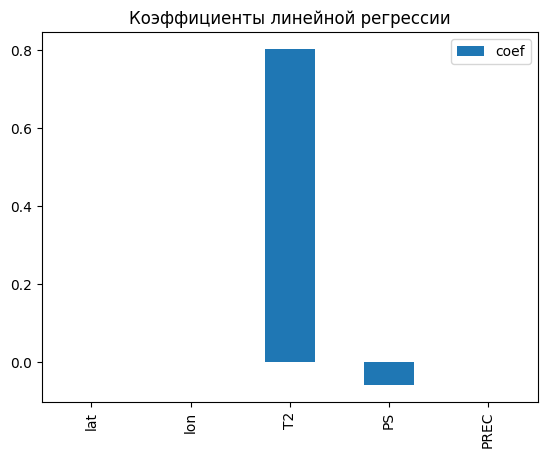

In [94]:
coefs = pd.DataFrame(model.coef_, X.columns, columns=['coef']) 
display(coefs)
coefs.plot.bar()
plt.title('Коэффициенты линейной регрессии')

**Наибольший коэффициент линейной регрессии**, как и следовало ожидать, получаем для температуры воздуха на уровне 2 м (температура поверхности и воздуха на 2 м - **крайне взаимосвязанные и взаимообуславливающие** друг друга показатели). Т.е. **наиболее значительным** "предиктором" ТПО выступает именно Т2. На "промежуточном" месте находится коэффициент регрессии между ТПО и ДУМ - важно также отметить, что он <u>отрицателен</u>, т.е. при <u>увеличении</u> давления наблюдается <u>уменьшение</u> температуры (*ночное выхолаживание поверхности в условиях ясной погоды*). **Наименьшее значение** имеет коэффициент регрессии ТПО по АО (слабое влияние в <u>положительную</u> сторону) - моделирование поля осадков представляют собой достаточно трудную задачу и связь между ним и полем ТПО крайне <u>сложна</u>.